# Set paths

DEVEL_SRC must contain the directory use-cases and pykhaos

In [2]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when '-' is removed from name, remove also this line and adapt imports 
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
# AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
# if AMDOCS_SRC not in sys.path: 
#     sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "out_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
        
from project.project_generic import Project

import pykhaos.utils.notebooks as nb

import time
start_time = time.time()

RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    # feel free from commenting this line and the other ones that begin with "%%notify" if you do not have 
    # the extension installed or copy de lib from /var/SP/data/home/csanc109/lib/external_libs/jupyternotify/
    %load_ext jupyternotify 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20190308-132650 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/out_20190308_132650.log
20190308-132650 [DEBUG] $HOME=/home/csanc109
20190308-132650 [DEBUG] matplotlib data path /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/matplotlib/mpl-data
20190308-132650 [DEBUG] loaded rc file /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc
20190308-132650 [DEBUG] matplotlib version 2.2.3
20190308-132650 [DEBUG] interactive is False
20190308-132650 [DEBUG] platform is linux2
20190308-132650 [DEBUG] loaded modules: ['_multiprocessing', 'IPython.core.error', 'ipython_genutils.py3compat', 'traitlets.config.sys', 'concurrent.futures.types', 'ipykernel.parentpoller', 'traitlets.config.decorator', 'ctypes.os', 'pexpect.select', 'runpy', 'gc', 'numpy.lib.numpy', 'pty', 'prompt_toolkit.terminal.vt100_output', 'prompt_toolkit.key_binding.six', 'dateutil.parser.dateutil', 'pygments.filters', 'IPython.utils.pprint', 'numpy.core.i

20190308-132650 [DEBUG] CACHEDIR=/home/csanc109/.cache/matplotlib
20190308-132650 [DEBUG] Using fontManager instance from /home/csanc109/.cache/matplotlib/fontList.json
20190308-132650 [DEBUG] backend agg version v2.2
20190308-132650 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown
20190308-132650 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown


<IPython.core.display.Javascript object>

In [3]:
from pyspark.sql import Row, DataFrame, Column, Window
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf, when, desc, asc, to_date, create_map, sum as sql_sum
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
from itertools import chain

## Start spark context

In [4]:
from churn.utils.general_functions import init_spark
spark = init_spark("spark_model")
sc = spark.sparkContext

Ended spark session: 35.1641249657 secs | default parallelism=4


# EDIT: Input file for training the model

In [5]:
DP_FILENAME = "/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete"


# Config 

In [6]:
cat_cols = ['prepaid_nacionalidad', 'prepaid_tipo_documento_comprador', 'tariffs_Plan', 'campaign_CAMPAIGNCODE', 'campaign_CREATIVIDAD', 'campaign_CELLCODE',
           'campaign_CANAL','campaign_EsRespondedor']
numerical_feats = ['prepaid_num_prepago', 'prepaid_num_pospago', 'prepaid_age_in_years', 'prepaid_days_since_fx_1llamada', 'tariffs_MOU', 'tariffs_TOTAL_LLAMADAS', 'tariffs_TOTAL_SMS',  'tariffs_MOU_Week',
                 'tariffs_LLAM_Week', 'tariffs_SMS_Week', 'tariffs_MOU_Weekend', 'tariffs_LLAM_Weekend', 'tariffs_SMS_Weekend', 'tariffs_MOU_VF', 'tariffs_LLAM_VF', 'tariffs_SMS_VF', 'tariffs_MOU_Fijo',
                 'tariffs_LLAM_Fijo', 'tariffs_SMS_Fijo', 'tariffs_MOU_OOM', 'tariffs_LLAM_OOM', 'tariffs_SMS_OOM', 'tariffs_MOU_Internacional', 'tariffs_LLAM_Internacional', 'tariffs_SMS_Internacional',
                 'tariffs_ActualVolume', 'tariffs_Num_accesos',  'tariffs_Num_Cambio_Planes', 'tariffs_LLAM_COMUNIDAD_SMART', 'tariffs_MOU_COMUNIDAD_SMART', 'tariffs_LLAM_SMS_COMUNIDAD_SMART',
                 'tariffs_Flag_Uso_Etnica', 'tariffs_cuota_SMART8', 'tariffs_cuota_SMART12', 'tariffs_cuota_SMART16', 'campaign_days_since_DATEID']
noninf_feats = ['prepaid_msisdn']

feat_cols = numerical_feats # notebook is not still prepared for categoricals.

label_col = 'label'

In [24]:
def prepare_df(filename):
    inittrdf = spark.read.option("delimiter", "|").option("header", True).csv(filename)
    
    cols_to_drop = [col_ for col_ in inittrdf.columns if col_.startswith("in_pospago")]
    cols_to_drop += ['prepaid_x_fecha_nacimiento', 'prepaid_partitioned_month', 'prepaid_fx_1llamada']
    
    inittrdf = inittrdf.drop(*cols_to_drop)
    if "migrated_to_postpaid" in inittrdf.columns:
        inittrdf = inittrdf.withColumnRenamed("migrated_to_postpaid", "label")
    for col_ in numerical_feats:
        inittrdf = inittrdf.withColumn(col_, col(col_).cast("float"))
    if label_col in inittrdf.columns:
        inittrdf = inittrdf.withColumn(label_col, col(label_col).cast("integer"))
    return inittrdf

# Read file for training the model

In [ ]:
inittrdf = prepare_df(DP_FILENAME)

In [8]:
[unbaltrdf, valdf] = inittrdf.randomSplit([0.7, 0.3], 1234)
#unbaltrdf.repartition(400)

#print "[Info FbbChurn] " + time.ctime() + " Total number of training samples is : " + str(unbaltrdf.count())

unbaltrdf.describe('label').show()

print "[Info FbbChurn] " + time.ctime() + " Stat description of the target variable printed above"

# 1.2. Balanced df for training

unbaltrdf.groupBy('label').agg(sql_count('*')).show()

print "[Info FbbChurn]" + time.ctime() + " Count on label column for unbalanced tr set showed above"

from churn.models.fbb_churn_amdocs.utils_general import balance_df2
trdf = balance_df2(unbaltrdf, 'label')

trdf.groupBy('label').agg(sql_count('*')).show()

print "[Info FbbChurn] " + time.ctime() + " Count on label column for balanced tr set showed above"

# 1.3. Feature selection

# allFeats = trdf.columns

for f in noninf_feats:
    print "[Info FbbChurn] Non-informative feat: " + f


+-------+--------------------+
|summary|               label|
+-------+--------------------+
|  count|             1673170|
|   mean|0.004475337234112493|
| stddev|  0.0667481179775881|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

[Info FbbChurn] Fri Mar  8 13:27:50 2019 Stat description of the target variable printed above
+-----+--------+
|label|count(1)|
+-----+--------+
|    1|    7488|
|    0| 1665682|
+-----+--------+

[Info FbbChurn]Fri Mar  8 13:28:13 2019 Count on label column for unbalanced tr set showed above
[Info balance_df2] Dataframe has been balanced - Total number of rows is 15114
+-----+--------+
|label|count(1)|
+-----+--------+
|    1|    7495|
|    0|    7619|
+-----+--------+

[Info FbbChurn] Fri Mar  8 13:28:49 2019 Count on label column for balanced tr set showed above
[Info FbbChurn] Non-informative feat: prepaid_msisdn


# Model

In [13]:

logger.info("Feat cols = {}".format(",".join(feat_cols)))

assembler = VectorAssembler(inputCols = feat_cols, outputCol = "features")

classifier = RandomForestClassifier(featuresCol="features", \
                                    labelCol="label", \
                                    maxDepth=15, \
                                    maxBins=32, \
                                    minInstancesPerNode=50, \
                                    impurity="gini", \
                                    featureSubsetStrategy="sqrt", \
                                    subsamplingRate=0.7, \
                                    numTrees=600, \
                                    seed = 1234)

pipeline = Pipeline(stages= [assembler, classifier])

model = pipeline.fit(trdf)

from churn.models.fbb_churn_amdocs.utils_model import getOrderedRelevantFeats
feat_importance = getOrderedRelevantFeats(model, feat_cols, 'f', 'rf')

for fimp in feat_importance:
    print "[Info FbbChurn] Imp feat " + str(fimp[0]) + ": " +  str(fimp[1])

# EVALUATION
# TODO: to include model calibration

# Calibration
#calibmodel = get_calibration_function2(spark, model, valdf, 'label', 10)
#getScore = udf(lambda prob: float(prob[1]), DoubleType())

getScore = udf(lambda prob: float(prob[1]), DoubleType())


# Train
tr_preds_df = model.transform(trdf).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))

# Train evaluation
trPredictionAndLabels = tr_preds_df.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], float(r['label'])))
trmetrics = BinaryClassificationMetrics(trPredictionAndLabels)





20190308-133601 [INFO ] Feat cols = prepaid_num_prepago,prepaid_num_pospago,prepaid_age_in_years,prepaid_days_since_fx_1llamada,tariffs_MOU,tariffs_TOTAL_LLAMADAS,tariffs_TOTAL_SMS,tariffs_MOU_Week,tariffs_LLAM_Week,tariffs_SMS_Week,tariffs_MOU_Weekend,tariffs_LLAM_Weekend,tariffs_SMS_Weekend,tariffs_MOU_VF,tariffs_LLAM_VF,tariffs_SMS_VF,tariffs_MOU_Fijo,tariffs_LLAM_Fijo,tariffs_SMS_Fijo,tariffs_MOU_OOM,tariffs_LLAM_OOM,tariffs_SMS_OOM,tariffs_MOU_Internacional,tariffs_LLAM_Internacional,tariffs_SMS_Internacional,tariffs_ActualVolume,tariffs_Num_accesos,tariffs_Num_Cambio_Planes,tariffs_LLAM_COMUNIDAD_SMART,tariffs_MOU_COMUNIDAD_SMART,tariffs_LLAM_SMS_COMUNIDAD_SMART,tariffs_Flag_Uso_Etnica,tariffs_cuota_SMART8,tariffs_cuota_SMART12,tariffs_cuota_SMART16,campaign_days_since_DATEID


[Info FbbChurn] Imp feat tariffs_MOU_VF: 0.10205106073760442
[Info FbbChurn] Imp feat tariffs_LLAM_VF: 0.09950515929900287
[Info FbbChurn] Imp feat tariffs_ActualVolume: 0.09219025441452952
[Info FbbChurn] Imp feat tariffs_TOTAL_LLAMADAS: 0.08794113613503185
[Info FbbChurn] Imp feat tariffs_Num_accesos: 0.08141114719357084
[Info FbbChurn] Imp feat tariffs_LLAM_Week: 0.0691205719718031
[Info FbbChurn] Imp feat prepaid_days_since_fx_1llamada: 0.058720686435507444
[Info FbbChurn] Imp feat prepaid_num_pospago: 0.05366907126490554
[Info FbbChurn] Imp feat tariffs_MOU_Week: 0.051041618807041056
[Info FbbChurn] Imp feat tariffs_MOU: 0.04871471321766864
[Info FbbChurn] Imp feat tariffs_LLAM_OOM: 0.035225720269220696
[Info FbbChurn] Imp feat tariffs_MOU_OOM: 0.03290104524926101
[Info FbbChurn] Imp feat prepaid_age_in_years: 0.03264339025514904
[Info FbbChurn] Imp feat tariffs_MOU_Weekend: 0.030986110059125747
[Info FbbChurn] Imp feat tariffs_LLAM_Weekend: 0.024386259759344095
[Info FbbChurn] Im

# Evaluation

In [14]:
# Test eval

tt_preds_df = model.transform(valdf).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))

# Evaluation
ttPredictionAndLabels = tt_preds_df.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], float(r['label'])))
ttmetrics = BinaryClassificationMetrics(ttPredictionAndLabels)

In [15]:
print("[Info FbbChurn] " + time.ctime() + " Area under ROC(tr) = " + str
    (trmetrics.areaUnderROC) + " - Area under ROC(tt) = " + str(ttmetrics.areaUnderROC))


from churn.models.fbb_churn_amdocs.utils_model import get_lift
lift = get_lift(tt_preds_df, 'model_score', 'label', 40)

for d ,l in lift:
    print str(d) + ": " + str(l)

[Info FbbChurn] Fri Mar  8 13:41:07 2019 Area under ROC(tr) = 0.728203606361 - Area under ROC(tt) = 0.723991746899
[Info get_lift] Computing lift
[Info get_lift] Computing lift - Ref Prevalence for class 1: 0.00447615441895
[Info get_deciles] Computing deciles
40.0: 4.28138768809
39.0: 3.27718823899
38.0: 2.46750596676
37.0: 2.24553774222
36.0: 1.89499955329
35.0: 1.89082355179
34.0: 1.74516363018
33.0: 1.74399730626
32.0: 1.64652394674
31.0: 1.40506952787
30.0: 1.26168213097
29.0: 1.21230829029
28.0: 1.24383609087
27.0: 0.964488762485
26.0: 1.37683260006
25.0: 0.943437731974
24.0: 0.817339225359
23.0: 0.745889897994
22.0: 0.835797481476
21.0: 0.719104899607
20.0: 0.70407335297
19.0: 0.611792026284
18.0: 0.450923470921
17.0: 0.522238231598
16.0: 0.566660887587
15.0: 0.454782363487
14.0: 0.533967466308
13.0: 0.486451685686
12.0: 0.442288134091
11.0: 0.402420138351
10.0: 0.455956572228
9.0: 0.350355591229
8.0: 0.350814286247
7.0: 0.321859211523
6.0: 0.263435003751
5.0: 0.263568941211
4.0

# EDIT: Predict section

In [25]:
predict_yyyymm = "201901"
FILE_FOR_PREDICT = '/user/csanc109/projects/pre2post/data/unlabeled/df_all_{0}_{0}_M1_classical_complete'.format(predict_yyyymm)

df_pred = prepare_df(FILE_FOR_PREDICT)
pr_preds_df = model.transform(trdf).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))


+--------------+--------------------+-------------------+-------------------+--------------------+--------------------------------+------------------------------+-----------+----------------------+-----------------+----------------+-----------------+----------------+-------------------+--------------------+-------------------+--------------+---------------+--------------+----------------+-----------------+----------------+---------------+----------------+---------------+-------------------------+--------------------------+-------------------------+--------------------+-------------------+------------+-------------------------+----------------------------+---------------------------+--------------------------------+-----------------------+--------------------+---------------------+---------------------+-----+---------------------+--------------------+-----------------+--------------+----------------------+--------------------------+--------------------+--------------------+-------------

In [ ]:
# Preparing the dataframe for delivery

In [51]:
pr_preds_df = pr_preds_df.withColumn("prepaid_msisdn", col("prepaid_msisdn").cast("string"))
df_scored_hidden = pr_preds_df.select('prepaid_msisdn', 'model_score').toPandas()
df_scored_hidden["prepaid_msisdn"] = df_scored_hidden["prepaid_msisdn"].apply(lambda ll: str(ll))
df_scored_hidden.rename(columns={"prepaid_msisdn" : "msisdn_hidden", "model_score" : "score"}, inplace=True)
df_scored_hidden["score"].max()

0.838063546156047

In [ ]:
# Checking scores

20190308-135917 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


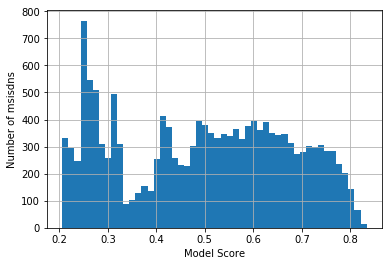

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

plt.figure()
n, bins, patches = plt.hist(df_scored_hidden["score"], bins=50)
plt.xlabel('Model Score')
plt.ylabel('Number of msisdns')
#plt.title(filename_pred)
plt.grid(True)
# #plt.show()

## Prepare delivery

Predictions are stored in a table, whose name is stored in variable 'name_table_anonymized'

### Save predictions in a table

In [55]:
PROJECT_NAME = "pre2post"
CAMPAIGN_DATE = "201903"

In [53]:
project_name = PROJECT_NAME
campaign_date_label = CAMPAIGN_DATE
df_predictions = df_scored_hidden
from pykhaos.utils.constants import WHOAMI
from Pre2post_bdp.model.delivery.prepare_delivery import save_pred_as_table, desanonimizar, deliver_table

dir_download = os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "download", project_name, "")
dir_delivery = os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "delivery", project_name, "")
name_table_anonymized = 'tests_es.{}_tmp_{}_{}_notprepared'.format(WHOAMI, project_name, campaign_date_label )
name_table_deanonymized = 'tests_es.{}_tmp_{}_{}_prepared'.format(WHOAMI, project_name, campaign_date_label )
name_file_delivery = '{}_delivery_{}_{}'.format(project_name, campaign_date_label ,
                                                dt.datetime.now().strftime("%Y%m%d_%H%M%S"))

print(name_table_anonymized,name_table_deanonymized,name_file_delivery)
save_pred_as_table(spark, df_predictions, name_table_anonymized)
print("df_predictions saved as table '{}'".format(name_table_anonymized))


('tests_es.csanc109_tmp_pre2post_201903_notprepared_kkkk', 'tests_es.csanc109_tmp_pre2post_201903_prepared_kkkkk', 'pre2post_delivery_201903_20190308_140236')
Created table tests_es.csanc109_tmp_pre2post_201903_notprepared_kkkk
df_predictions saved as table 'tests_es.csanc109_tmp_pre2post_201903_notprepared_kkkk'


### Deanonymized table

Take table created in previous step and deanonymize the msisdn

In [66]:
from Pre2post_bdp.model.delivery.prepare_delivery import save_pred_as_table, desanonimizar, deliver_table

# sh /var/SP/data/home/csanc109/src/desanonimizar_jsotovi2/desanonimizar_csanc109.sh --fields msisdn=DE_MSISDN --overwrite tests_es.csanc109_tmp_pre2post_201902_notprepared tests_es.csanc109_tmp_pre2post_201902_prepared
# !!!!!!!  If "desanonimizar" does not end, run the command line by hand in a Terminal. Remember to update the line with the proper table names.
spark.sql("refresh table {}".format(name_table_anonymized))
desanonimizar(name_table_anonymized,name_table_deanonymized)

Starting process for desanonimizar....


KeyboardInterrupt: 

### Create csv

In [62]:
# Generate the delivery file (the csv we have to sent to Everis)
deliver_table(spark, name_table_deanonymized,name_file_delivery,dir_download,dir_delivery,local_dir_deliverables=None)

AnalysisException: u"Table or view 'csanc109_tmp_pre2post_201903_prepared_kkkkk' not found in database 'tests_es';"

In [ ]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator


# indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid='skip') for c in cat_cols]
# encoders = [OneHotEncoder(inputCol=c + "_idx", outputCol = c + "_enc") for c in cat_cols]

